In [ ]:
# Compute edit distance with WFST

# https://github.com/revdotcom/fstalign/blob/develop/src/fstalign.cpp#L197
# https://www.statmt.org/wmt16/pdf/W16-2324.pdf
# https://aclanthology.org/P14-2102.pdf
# https://github.com/k2-fsa/k2/issues/746

In [1]:
import sys
sys.path.insert(0,'/exp/rhuang/meta/icefall/egs/librispeech/ASR/conformer_ctc2_noseg')
sys.path.insert(0,'/exp/rhuang/meta/k2/k2/python')
sys.path.insert(0,'/exp/rhuang/meta/k2/temp.linux-x86_64-cpython-310/lib')
sys.path.insert(0,'/exp/rhuang/meta/icefall')

In [2]:
import k2
import sentencepiece as spm
import torch
import pywrapfst as openfst

In [3]:
sp = spm.SentencePieceProcessor()
sp.load("/exp/rhuang/meta/icefall/egs/librispeech/ASR/data/lang_bpe_500/bpe.model")

True

In [4]:
texts = ["I DO NOT WANT TO INCUR", "THERE WAS LOVERS LIKE DOGS", "RED APP I"]
word_ids_list = sp.encode(texts, out_type=int)
word_ids_list

[[19, 100, 69, 414, 10, 15, 18, 79],
 [153, 33, 370, 23, 3, 231, 100, 52, 3],
 [49, 12, 5, 145, 19]]

In [127]:
# word_ids_list1 = [24, 102, 70, 393, 12, 17, 19, 80]
# word_ids_list2 = [24, 102, 392, 70, 12, 19, 80]

# word_ids_list1 = list(range(800, 900)) + [24, 102, 70, 393, 12, 17, 19, 80] + list(range(800, 900))
# word_ids_list2 = [24, 102, 392, 70, 12, 19, 80]

word_ids_list1 = [77] * 10000 + [24, 102, 70, 393, 12, 17, 19, 80] + [77] * 10000
word_ids_list2 = [24, 102, 392, 70, 12, 19, 80]

In [120]:
# graph1 = k2.ctc_graph([word_ids_list1], modified=False, device='cpu')[0]
# graph2 = k2.ctc_graph([word_ids_list2], modified=False, device='cpu')[0]

# graph1 = k2.linear_fsa([word_ids_list1], device='cpu')[0]
# graph2 = k2.linear_fsa([word_ids_list2], device='cpu')[0]

graph1 = k2.linear_fst(labels=[word_ids_list1], aux_labels=[word_ids_list1])[0]
graph2 = k2.linear_fst(labels=[word_ids_list2], aux_labels=[word_ids_list2])[0]

In [21]:
k2.to_dot(graph1)

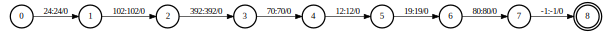

In [22]:
k2.to_dot(graph2)

In [84]:
def get_linear_fst(word_ids_list, blank_id=0, max_symbol_id=1000, input_side=True, return_str=False):
    graph = k2.linear_fst(labels=[word_ids_list], aux_labels=[word_ids_list])[0]

    max_symbol_id += 1

    c_str = k2.to_str_simple(graph)
    arcs = c_str.strip().split("\n")
    arcs = [x.strip() for x in arcs if len(x.strip()) > 0]
    final_state = int(arcs[-1])

    arcs = arcs[:-1]
    arcs = [tuple(map(int, a.split())) for a in arcs]

    new_arcs = []
    for ss, ee, l1, l2, w in arcs:
        if l1 > 0:
            # substitution
            if input_side:
                new_arcs.append([ss, ee, max_symbol_id, l2, -1])
            else:
                new_arcs.append([ss, ee, l1, max_symbol_id, -1])
            
            # deletion
            new_arcs.append([ss, ee, l1, blank_id, -2])
        
        # insertion
        if input_side:
            new_arcs.append([ss, ss, max_symbol_id, blank_id, -2])
        else:
            new_arcs.append([ss, ss, blank_id, max_symbol_id, -2])
    
    new_arcs = arcs + new_arcs
    new_arcs.append([final_state])

    new_arcs = sorted(new_arcs, key=lambda arc: arc[0])
    new_arcs = [[str(i) for i in arc] for arc in new_arcs]
    new_arcs = [" ".join(arc) for arc in new_arcs]
    new_arcs = "\n".join(new_arcs)

    if return_str:
        return new_arcs
    else:
        fst = k2.Fsa.from_str(new_arcs, acceptor=False)
        fst = k2.arc_sort(fst)
        return fst

In [128]:
graph1 = get_linear_fst(word_ids_list1, max_symbol_id=1000, blank_id=0, input_side=False, return_str=False)
graph2 = get_linear_fst(word_ids_list2, max_symbol_id=1000, blank_id=0, input_side=True, return_str=False)

In [37]:
# print(graph1)
# graph1.arcs.values()

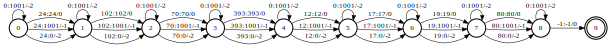

In [86]:
k2.to_dot(graph1)

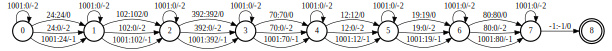

In [87]:
k2.to_dot(graph2)

In [129]:
rs = k2.compose(graph1, graph2, treat_epsilons_specially=True)
rs = k2.connect(rs)
rs = k2.remove_epsilon_self_loops(rs)
# rs = k2.arc_sort(rs)
rs = k2.top_sort(rs)  # top-sort is needed: https://github.com/k2-fsa/k2/issues/746#issuecomment-856503238

rs.shape, rs.num_arcs

((160073, None), 600260)

In [113]:
rs.arcs.values()

tensor([[          0,           1,          24, -1073741824],
        [          0,           3,          24,           0],
        [          0,           3,          24, -1073741824],
        ...,
        [         69,          71,          80, -1069547520],
        [         70,          71,           0, -1069547520],
        [         71,          72,          -1,           0]],
       dtype=torch.int32)

In [103]:
rs.labels

tensor([ 24,  24,   0,  24,  24, 102, 102,   0, 102, 102,   0,  24,  24,   0,
        102, 102,   0,  70,  70,   0, 102, 102,   0,  70,  70,   0,  24,  24,
          0,  70,  70,  70,  70,   0,  70,  70,   0, 393, 393,   0, 393, 393,
          0, 102, 102,   0, 393, 393,   0,  24,  24,   0, 393, 393,   0, 393,
        393,   0,  70,  70,   0,  12,  12,   0,  12,  12,  12,  12,   0,  12,
         12,   0, 102, 102,   0,  12,  12,   0,  24,  24,   0,  12,  12,   0,
        393, 393,   0,  12,  12,   0,  70,  70,   0,  17,  17,   0,  17,  17,
          0,  17,  17,   0,  17,  17,   0, 102, 102,   0,  17,  17,   0,  24,
         24,   0,  17,  17,   0, 393, 393,   0,  12,  12,   0,  17,  17,   0,
         70,  70,   0,  19,  19,   0,  19,  19,   0,  19,  19,  19,  19,   0,
         19,  19,   0,  19,  19,   0, 102, 102,   0,  19,  19,   0,  24,  24,
          0,  19,  19, 393,  12,  17,  19,  70,   0,  80,  80,   0,  80,  80,
          0,  80,  80,   0,  80,  80,  80,  80,   0,  80,  80,  

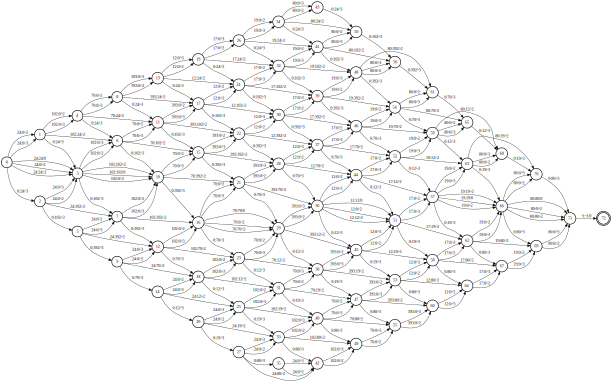

In [114]:
k2.to_dot(rs)

In [82]:
from icefall.decode import get_lattice, one_best_decoding
from icefall.utils import get_alignments, get_texts, get_texts_with_timestamp

In [130]:
rs_vec = k2.create_fsa_vec([rs])

# best_path = one_best_decoding(
#     lattice=rs_vec,
#     use_double_scores=True,
# )

best_path = k2.shortest_path(rs_vec, use_double_scores=True)
best_path.shape, best_path.num_arcs

((1, None, None), 20009)

In [116]:
rs.properties
rs.properties_str

'"Valid|Nonempty|TopSorted|TopSortedAndAcyclic|MaybeAccessible|MaybeCoaccessible"'

In [124]:
k2.to_dot(best_path[0])

In [118]:
hyps = get_texts(best_path)
print(f"hyps={hyps}")

hyps=[[24, 102, 392, 70, 12, 19, 80]]


In [131]:
edit_distance = best_path.get_tot_scores(log_semiring=False, use_double_scores=False) / 2
edit_distance

tensor([-20003.])